### Import relevant libraries

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid

from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

### Load the Udemy Wikipedia visits dataset

In [2]:
%cd /content/drive/MyDrive/python_for_business_and_finance/Facebook_Prophet

df = pd.read_csv("Udemy_wikipedia_visits.csv")
df.head()

/content/drive/MyDrive/python_for_business_and_finance/Facebook_Prophet


,Date,Udemy,Easter,Christmas,Black Friday
0,1/1/2016,311,0,0,0
1,1/2/2016,564,0,0,0
2,1/3/2016,517,0,0,0
3,1/4/2016,652,0,0,0
4,1/5/2016,756,0,0,0


### Plot the timeseries

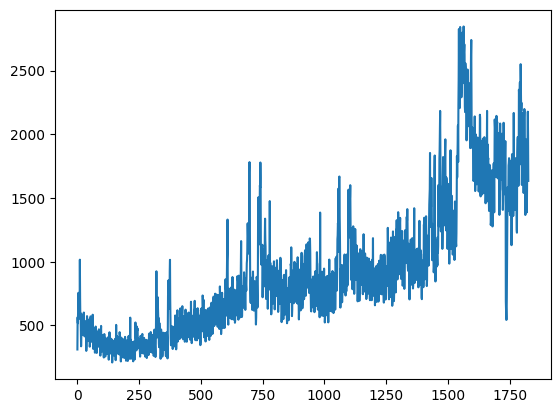

In [3]:
plt.plot(df["Udemy"])
plt.show()

### Data cleaning and preparation

In [4]:
# Transform Date variable into datetime
df['Date'] = pd.to_datetime(df['Date'], format = "%m/%d/%Y")
df.head()

,Date,Udemy,Easter,Christmas,Black Friday
0,2016-01-01,311,0,0,0
1,2016-01-02,564,0,0,0
2,2016-01-03,517,0,0,0
3,2016-01-04,652,0,0,0
4,2016-01-05,756,0,0,0


In [5]:
# Change column names for Prophet
df = df.rename(columns = {"Date":"ds", "Udemy":"y"})
df.head(1)

,ds,y,Easter,Christmas,Black Friday
0,2016-01-01,311,0,0,0


### Holiday

In [6]:
# Create Easter dataframe with lower window 5 days before Easter and upper window 2 days after Easter
easter_dates = df[df["Easter"] == 1]['ds']

easter = pd.DataFrame({"holiday":"Easter",
              "ds":easter_dates,
              "lower_window": -5,
              "upper_window": 2})

In [7]:
# Same as above for Black Friday but wider window
black_friday_dates = df[df['Black Friday'] == 1]['ds']

black_friday = pd.DataFrame({"holiday": "Black Friday",
                             "ds": black_friday_dates,
                             "lower_window": -7,
                             "upper_window": 5})

In [8]:
# combine holidays
holidays = pd.concat([easter, black_friday], axis = 0)
holidays

,holiday,ds,lower_window,upper_window
86,Easter,2016-03-27,-5,2
471,Easter,2017-04-16,-5,2
821,Easter,2018-04-01,-5,2
1206,Easter,2019-04-21,-5,2
1563,Easter,2020-04-12,-5,2
329,Black Friday,2016-11-25,-7,5
693,Black Friday,2017-11-24,-7,5
1057,Black Friday,2018-11-23,-7,5
1428,Black Friday,2019-11-29,-7,5
1792,Black Friday,2020-11-27,-7,5


In [9]:
# Remove Easter and Black Friday from original dataframe
df.drop(columns = ["Easter", "Black Friday"], inplace = True)
df.head(1)

,ds,y,Christmas
0,2016-01-01,311,0


### Prophet model

In [10]:
# Prepare train and test sets
test_days = 31
training = df.iloc[:-test_days, :]
testing = df.iloc[-test_days:, :]

print(training.tail(1), testing.head(1))

             ds     y  Christmas
1795 2020-11-30  2551          0              ds     y  Christmas
1796 2020-12-01  2393          0


In [11]:
# Inntantiate Prophet class
m = Prophet(growth = 'linear',
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = 'additive',
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05)

m.add_regressor('Christmas')

In [12]:
# Fit the data
m.fit(training)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsq2sfu46/47jojrr7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsq2sfu46/1r5_0493.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59629', 'data', 'file=/tmp/tmpsq2sfu46/47jojrr7.json', 'init=/tmp/tmpsq2sfu46/1r5_0493.json', 'output', 'file=/tmp/tmpsq2sfu46/prophet_modelnlmpxadt/prophet_model-20230908060002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:00:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:00:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [13]:
# Regressor coefficients
regressor_coefficients(m) # during Christmas visits drop by 268

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,additive,0.0,-268.186831,-268.186831,-268.186831


### Forecasting

In [14]:
# Create future dataframe
future = m.make_future_dataframe(periods = test_days,
                                 freq = 'D')
future = pd.concat([future, df.iloc[:, 2:]], axis = 1)
future

,ds,Christmas
0,2016-01-01,0
1,2016-01-02,0
2,2016-01-03,0
3,2016-01-04,0
4,2016-01-05,0
...,...,...
1822,2020-12-27,0
1823,2020-12-28,0
1824,2020-12-29,0
1825,2020-12-30,0


In [15]:
# Forecasting
forecast = m.predict(future)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Black Friday,Black Friday_lower,Black Friday_upper,Christmas,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-01-01,311.806287,179.096082,684.130846,311.806287,311.806287,0.0,0.0,0.0,0.0,...,-22.261446,-22.261446,-22.261446,145.667294,145.667294,145.667294,0.0,0.0,0.0,435.212135
1,2016-01-02,312.139765,57.260716,550.748324,312.139765,312.139765,0.0,0.0,0.0,0.0,...,-180.747244,-180.747244,-180.747244,169.457195,169.457195,169.457195,0.0,0.0,0.0,300.849716
2,2016-01-03,312.473243,117.671605,598.356852,312.473243,312.473243,0.0,0.0,0.0,0.0,...,-140.081369,-140.081369,-140.081369,192.036562,192.036562,192.036562,0.0,0.0,0.0,364.428436
3,2016-01-04,312.806721,351.666883,855.354769,312.806721,312.806721,0.0,0.0,0.0,0.0,...,75.578503,75.578503,75.578503,213.047842,213.047842,213.047842,0.0,0.0,0.0,601.433067
4,2016-01-05,313.140199,396.956963,893.937147,313.140199,313.140199,0.0,0.0,0.0,0.0,...,102.232010,102.232010,102.232010,232.160960,232.160960,232.160960,0.0,0.0,0.0,647.533169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,2020-12-27,2081.279823,1728.215336,2229.595745,2080.417944,2082.036097,0.0,0.0,0.0,0.0,...,-140.081369,-140.081369,-140.081369,39.975991,39.975991,39.975991,0.0,0.0,0.0,1981.174444
1823,2020-12-28,2083.182577,1981.667567,2469.980540,2082.123355,2084.108726,0.0,0.0,0.0,0.0,...,75.578503,75.578503,75.578503,64.615832,64.615832,64.615832,0.0,0.0,0.0,2223.376912
1824,2020-12-29,2085.085331,2030.867159,2531.875342,2083.862643,2086.139060,0.0,0.0,0.0,0.0,...,102.232010,102.232010,102.232010,89.686769,89.686769,89.686769,0.0,0.0,0.0,2277.004110
1825,2020-12-30,2086.988084,2057.588971,2536.060390,2085.665516,2088.128222,0.0,0.0,0.0,0.0,...,93.546762,93.546762,93.546762,114.803689,114.803689,114.803689,0.0,0.0,0.0,2295.338535


In [16]:
print(forecast.columns)

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'Black Friday', 'Black Friday_lower', 'Black Friday_upper', 'Christmas',
       'Christmas_lower', 'Christmas_upper', 'Easter', 'Easter_lower',
       'Easter_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'extra_regressors_additive',
       'extra_regressors_additive_lower', 'extra_regressors_additive_upper',
       'holidays', 'holidays_lower', 'holidays_upper', 'weekly',
       'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


In [17]:
# Holiday assessment
holiday = 'Easter'
forecast[(forecast[holiday].abs() > 0) & (forecast['ds'] >'2020-01-01')][['ds', holiday]]

,ds,Easter
1558,2020-04-07,-20.017371
1559,2020-04-08,-36.045867
1560,2020-04-09,3.830809
1561,2020-04-10,28.914986
1562,2020-04-11,76.213051
1563,2020-04-12,86.758055
1564,2020-04-13,84.724442
1565,2020-04-14,28.186069


### Accuracy assessment

In [18]:
# Extract last 'test_days' from forecast
predictions = forecast['yhat'].iloc[-test_days : ]

In [19]:
# Mean squared error and mean absolute error of predictions
print(f"MAE: {round(mean_absolute_error(testing['y'], predictions), 0)}, RMSE:{round(mean_squared_error(testing['y'], predictions)**(1/2), 0)}")

MAE: 200.0, RMSE:250.0


### Visualizing results

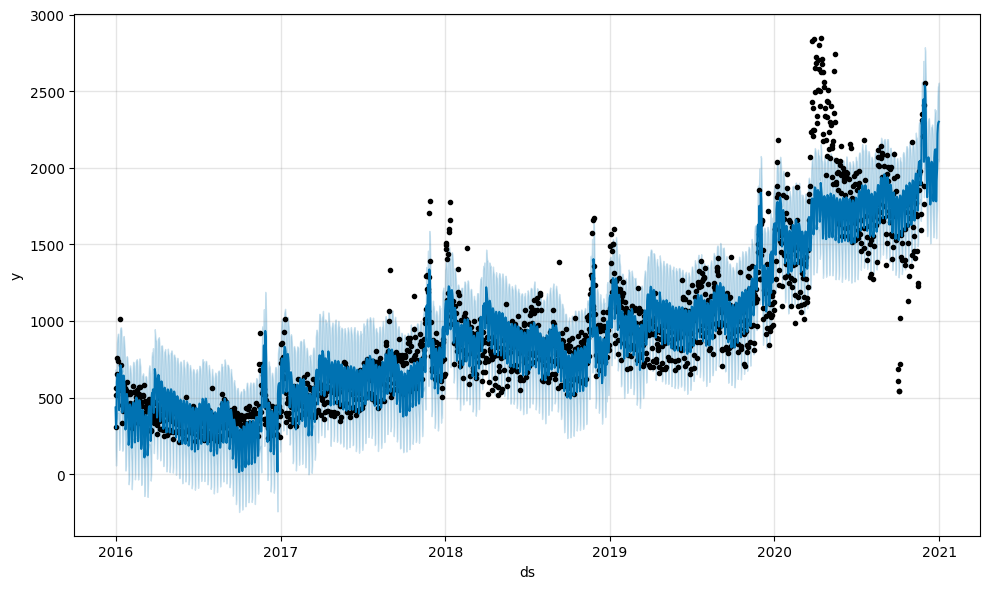

In [20]:
# Visualize the forecast
m.plot(forecast);

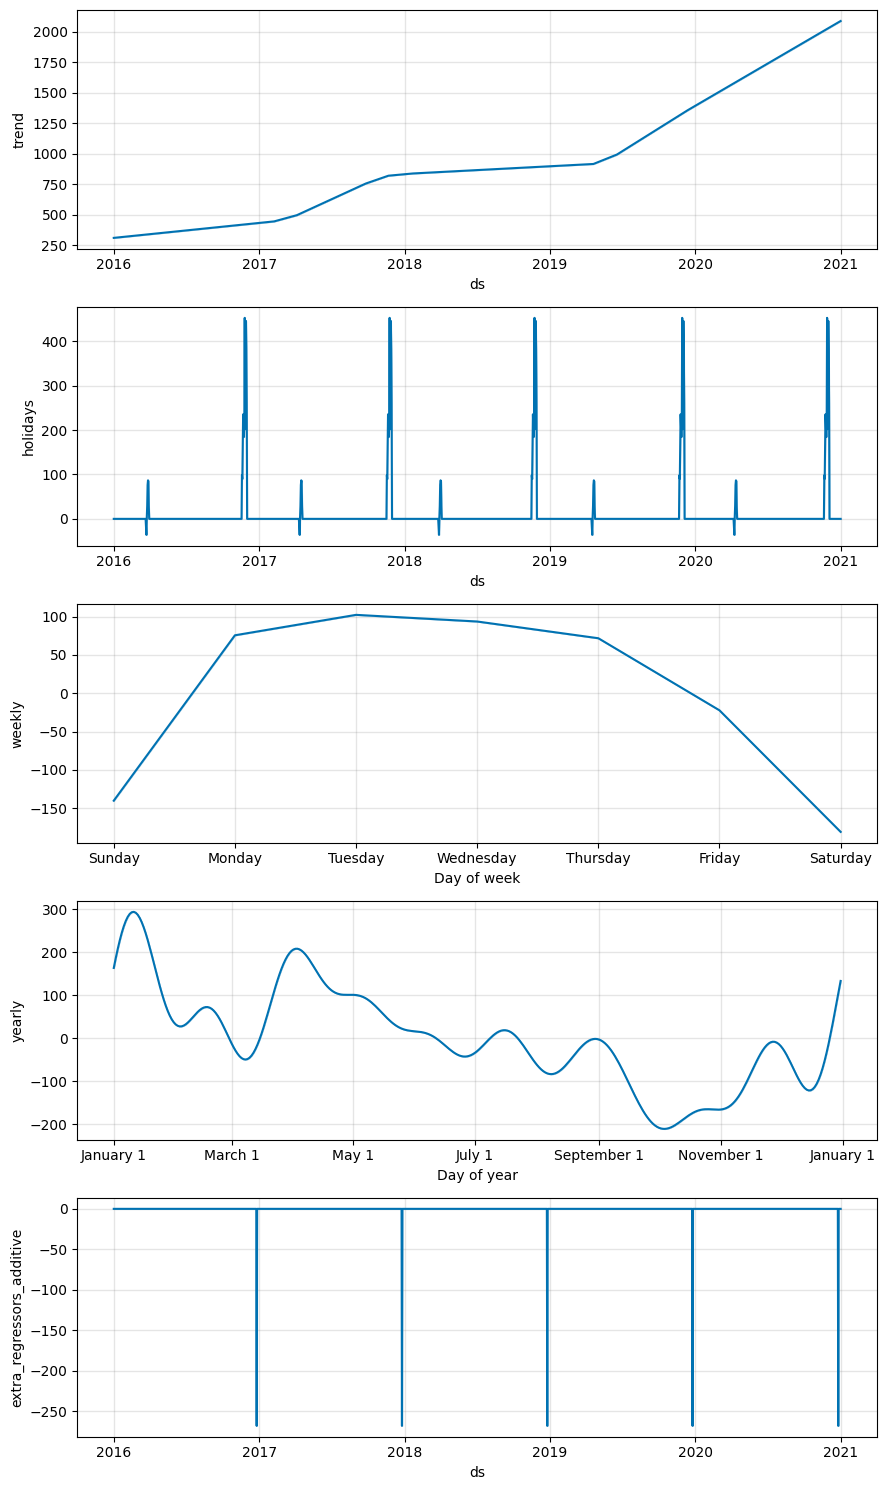

In [21]:
# Plot time series decomposition
m.plot_components(forecast);

### Cross-validation

In [ ]:
df_cv = cross_validation(model = m,
                 horizon = '31 days',
                 initial = '1450 days',
                 parallel = 'processes')



In [23]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-12-26,1280.939666,1151.209888,1417.777790,1165,2019-12-25
1,2019-12-27,1222.393957,1084.519879,1359.495980,1111,2019-12-25
2,2019-12-28,1101.092345,964.617088,1233.991856,1038,2019-12-25
3,2019-12-29,1163.717292,1039.945432,1295.250808,971,2019-12-25
4,2019-12-30,1371.544284,1243.238430,1503.959131,1192,2019-12-25


In [24]:
# Error assessment
print(f"MAE: {round(mean_absolute_error(df_cv['y'], df_cv['yhat']), 0)}, RMSE:{round(mean_squared_error(df_cv['y'], df_cv['yhat'])**(1/2), 0)}")

MAE: 400.0, RMSE:518.0


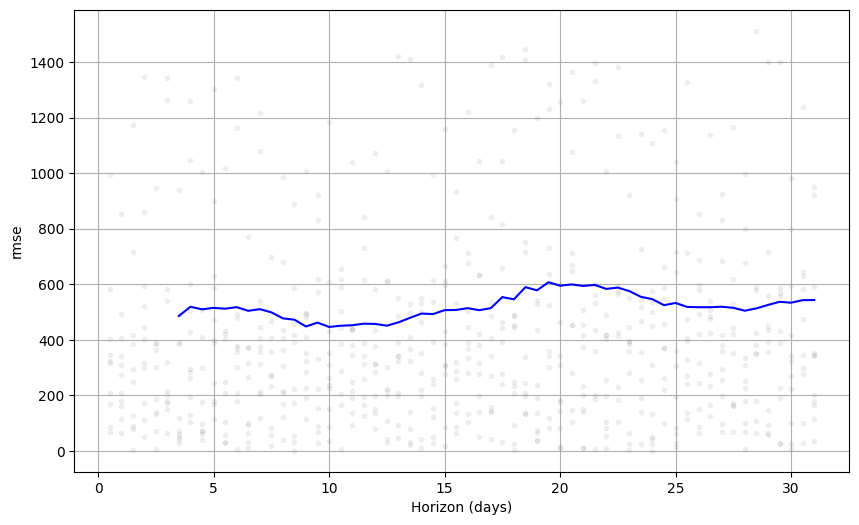

In [27]:
# Visualization
plot_cross_validation_metric(df_cv = df_cv,
                             metric = 'rmse');

### Parameter tuning

In [32]:
param_grid = {'seasonality_mode': ['additive', 'multiplicative'],
              'seasonality_prior_scale': [5, 10, 20],
              'holidays_prior_scale':[5, 10, 20],
              'changepoint_prior_scale':[0.01, 0.05, 0.1]}

grid = ParameterGrid(param_grid)
print(list(grid))

[{'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 20}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 10}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 20}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 5}, {'changepoint_prior_scale': 0.01, 'holidays_prior_scale': 10, 'seasonality_mode': 'additive', 'seasonality_p

In [ ]:
# to store results and errors
results = []
errors = []

for param in grid:
  # build the model
  m = Prophet(growth = 'linear',
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = param['seasonality_mode'],
            seasonality_prior_scale = param['seasonality_prior_scale'],
            holidays_prior_scale = param['holidays_prior_scale'],
            changepoint_prior_scale = param['changepoint_prior_scale'])
  m.add_regressor('Christmas')
  m.fit(training)
  # perform cross-validation
  df_cv = cross_validation(model = m,
                 horizon = '31 days',
                 initial = '1450 days',
                 parallel = 'processes')

  # compute and store error
  error = round(mean_absolute_error(df_cv['y'], df_cv['yhat']), 0)
  errors.append(error)